In this notebook, I will demonstrate how to fit a Gaussian Mixture Model to data.
I will show how different variations of the model compare to each other
- [ ] Initializing randomly vs. with k-means algorithm: accuracy and time to convergence
- [ ] Fitting constrained vs. unconstrained Gaussian component distributions: spherical, elliptical, or full-covariance

In [ ]:
%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
import jax.random as jr
import numpy as onp

import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange

from movmf.mixture_model import GaussianMixtureModel
from movmf.util import draw_confidence_ellipse

In [ ]:
import seaborn as sns
from matplotlib.colors import ListedColormap

categorical_cmap = ListedColormap(sns.color_palette('husl',9).as_hex())
categorical_cmap

## Generate data from a model

In [ ]:
def generate_observations(seed, n_mixtures, n_dims, n_samples=100, scales=[]):
    """Generate data-generating GMM and draw samples.
    
    Differs from gmm.initialize_random bc it provides control over scales.
    """
    
    seed_cat, seed_mean, seed_cov, seed_sample = jr.split(seed, 4)
    mixing_probs = jr.dirichlet(seed_cat, jnp.ones(n_mixtures))
    component_means = jr.normal(seed_mean, (n_mixtures, n_dims))

    if len(scales) == 0:
        scales = jr.uniform(seed_cov, (n_mixtures,), minval=1.e-3, maxval=3.)
    component_covs = jnp.tile(jnp.eye(n_dims), (n_mixtures, 1, 1))
    component_covs *= scales[:, None, None]
    
    true_gmm = GaussianMixtureModel(mixing_probs, component_means, component_covs)
    assgns, samples = true_gmm.sample(seed_sample, (n_samples,))
    return true_gmm, assgns, samples

In [ ]:
def split_data_by_assgn(assgns, *arrs):
    """Split data into a list of sets by assignment.

    NB: Does not catch that case when some mixtures may have 0 assignments.
    
    Params
        assgns[n]: unorder list of M mixture assignments
        arrs[n,...]: list of data arrays to be sorted
        
    Return
        *sorted_arrs: input arrays are split into lengths of length (M)
    """

    # Sort indices in ascending order
    idx_sort = onp.argsort(onp.asarray(assgns))
    sorted_assgns = assgns[idx_sort]
    sorted_arrs = [arr[idx_sort,...] for arr in arrs]

    # Split arrays by mixture
    _, idx_split = onp.unique(sorted_assgns, return_index=True)
    split_arrs = [onp.split(arr, idx_split[1:]) for arr in sorted_arrs]

    return split_arrs[0] if len(split_arrs)==1 else tuple(split_arrs)

In [ ]:
# Generate data from a Gaussian mixture model
seed = jr.PRNGKey(340212)
seed, seed_scale, seed_init = jr.split(seed, 3)

true_n_mixtures = 5
component_dim = 2
scales = jr.uniform(seed_scale, (true_n_mixtures,), minval=1e-3, maxval=0.5)
n_samples = 500
true_gmm, true_assgns, samples = generate_observations(
    seed_init, true_n_mixtures, component_dim, n_samples, scales
)

samples_by_mixture = split_data_by_assgn(true_assgns, samples)

In [ ]:
# Plot true GMM (3 std of ellipses) and observed samples (scatter) by mixture.
# Saturation of true GMM ellipse is indicative of its mixing probability

true_means = true_gmm._component_means.value
true_covs = true_gmm._component_covariances.value
true_probs = onp.asarray(true_gmm._mixing_probs.value)

for m, samples_m in enumerate(samples_by_mixture):
    c = categorical_cmap(m)
    
    plt.scatter(samples_m[:,0], samples_m[:,1], s=12, color=c)

    # Plot true GMM
    alpha = onp.maximum(true_probs[m], 0.05)
    draw_confidence_ellipse(true_means[m], true_covs[m], ax=plt.gca(),
                                       n_std=[1,2,3], edgecolor='k', facecolor=c, alpha=alpha)
plt.gca().set_aspect('equal')
plt.title(f'Data-generating GMM and samples (n={n_samples})')

## Now, let's create a randomly initialized GMM and fit it to the day

In [ ]:
seed, seed_init = jr.split(seed)
test_gmm = GaussianMixtureModel.initialize_random(seed, true_n_mixtures, component_dim)

lps = test_gmm.fit_em(samples, n_iters=100)

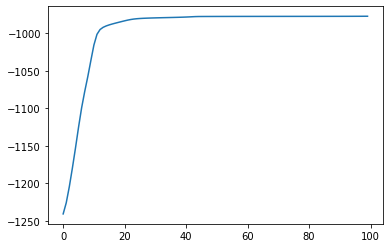

Text(0.5, 1.0, 'GMM fitten to data samples (n=500, n_iters=100)')

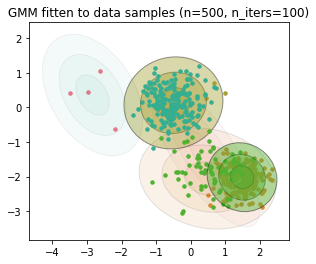

In [10]:
# Plot test GMM (3 std of ellipses) and observed samples (scatter) by mixture.
# Saturation of test GMM ellipse is indicative of its mixing probability
plt.plot(lps)
plt.xlabel('num iterations')
plt.xlabel('log prob')
plt.show()

test_means = onp.asarray(test_gmm._component_means.value)
test_covs = onp.asarray(test_gmm._component_covariances.value)
test_probs = onp.asarray(test_gmm._mixing_probs.value)

for m, samples_m in enumerate(samples_by_mixture):
    c = categorical_cmap(m)
    
    plt.scatter(samples_m[:,0], samples_m[:,1], s=12, color=c)

    # Plot test GMM
    alpha = onp.maximum(test_probs[m], 0.05)
    draw_confidence_ellipse(test_means[m], test_covs[m], ax=plt.gca(),
                            n_std=[1,2,3], edgecolor='k', facecolor=c, alpha=alpha)
plt.gca().set_aspect('equal')
plt.title(f'GMM fitten to data samples (n={n_samples}, n_iters={len(lps)})')